## Image resizing

Use conda env solaris

image size 512 with reflect
and without reflect

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import geopandas as gpd
from PIL import Image
import PIL.Image as pil_image
import cv2
from pathlib import Path
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import pandas as pd
import math
import shutil

In [3]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [4]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [5]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [6]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [7]:
CV_RESIZE_IMAGES = True
PIL_RESIZE_IMAGES = False
BORDER = cv2.BORDER_REFLECT_101

In [8]:
border = 'reflect'

In [9]:
img_size=512

In [10]:
def create_df(data_path, json, country, region):
    df = gpd.read_file(data_path/json)
    e=[country] * len(df)
    f=[region] * len(df)
    df['country'] = e
    df['region'] = f
    return df

In [11]:
df_list=[]
path_list= [colombia_rural, colombia_soacha, guatemala_mixco1, guatemala_mixco3,
         st_lucia_castries, st_lucia_dennery, st_lucia_gros_islet]
json_list=['train-borde_rural.geojson','train-borde_soacha.geojson','train-mixco_1_and_ebenezer.geojson','train-mixco_3.geojson',
          'train-castries.geojson','train-dennery.geojson','train-gros_islet.geojson']
country_list=['colombia','colombia','guatemala','guatemala','st_lucia','st_lucia','st_lucia']
region_list=['borde_rural','borde_soacha','mixco_1_and_ebenezer','mixco_3','castries','dennery','gros_islet']
for data_path, json, country, region in zip(path_list,json_list,country_list,region_list):
    df_list.append(create_df(data_path, json, country, region))

In [12]:
df_all = pd.concat(df_list)

In [13]:
df_all.tail()

,id,roof_material,verified,geometry,country,region
1962,7a22ddec,healthy_metal,False,POLYGON ((-60.95292861319552 14.08097492272584...,st_lucia,gros_islet
1963,7a2f73ea,healthy_metal,False,POLYGON ((-60.94701386937614 14.08085025943012...,st_lucia,gros_islet
1964,7a34ffa4,healthy_metal,False,"POLYGON ((-60.95234511737379 14.0800326733645,...",st_lucia,gros_islet
1965,7a41560a,healthy_metal,False,POLYGON ((-60.94874752294435 14.08058451924303...,st_lucia,gros_islet
1966,7a283ad0,healthy_metal,False,"POLYGON ((-60.9486881797622 14.08073516481083,...",st_lucia,gros_islet


In [14]:
#cant save to csv with geometry
df_all.drop(columns=['geometry'],inplace=True)

In [15]:
#df_all.to_csv(data_dir/'df_train_all.csv', index=False)

In [16]:
#note no geo json from st_lucia castries or gros_islet
df_t=[]
t_path_list= [colombia_rural, colombia_soacha, guatemala_mixco1, guatemala_mixco3, st_lucia_dennery]
t_json_list=['test-borde_rural.geojson','test-borde_soacha.geojson','test-mixco_1_and_ebenezer.geojson',
           'test-mixco_3.geojson','test-dennery.geojson']
t_country_list=['colombia','colombia','guatemala','guatemala','st_lucia']
t_region_list=['borde_rural','borde_soacha','mixco_1_and_ebenezer','mixco_3','dennery']
for data_path, json, country, region in zip(t_path_list,t_json_list,t_country_list,t_region_list):
    df_t.append(create_df(data_path, json, country, region))

In [17]:
df_test = pd.concat(df_t)

In [18]:
df_test.head()

,id,geometry,country,region
0,7a4d630a,POLYGON ((-74.15899863012478 4.554633886101286...,colombia,borde_rural
1,7a4bbbd6,POLYGON ((-74.15954898159198 4.554632289170956...,colombia,borde_rural
2,7a4ac744,POLYGON ((-74.15891773014597 4.555085254168239...,colombia,borde_rural
3,7a4881fa,POLYGON ((-74.15887087175038 4.555061673990481...,colombia,borde_rural
4,7a4aa4a8,POLYGON ((-74.15881842391423 4.555044808798753...,colombia,borde_rural


In [19]:
#cant save to csv with geometry
df_test.drop(columns=['geometry'],inplace=True)

In [20]:
#df_test.to_csv(data_dir/'df_test_all.csv', index=False)

#### get average image size

In [21]:
def img_type_av_sz(fn_list):
    widths = []
    heights = []
    for im in fn_list:
        #100 x faster than open_image(img_f)
        w,h=pil_image.open(im).size
        widths.append(w)
        heights.append(h)
    av_w = sum(widths)/len(widths)
    av_h = sum(heights)/len(heights)
    print(f'avg width: {av_w}, avg height: {av_h}, max w: {max(widths)}, min w: {min(widths)}, max h: {max(heights)}, min h: {min(heights)}')
    return widths, heights


In [22]:
path

PosixPath('data/colombia_borde_rural/cropped')

In [23]:
fnames = [path/'train'/f'{f}' for f in listdir(path/'train') if isfile(join(path/'train', f))]

In [24]:
fnames[0]

PosixPath('data/colombia_borde_rural/cropped/train/7a1e7446.tif')

In [25]:
test_fnames = [path/'train'/f'{f}' for f in listdir(path/'test') if isfile(join(path/'test', f))]

In [26]:
widths, heights=img_type_av_sz(fnames)

avg width: 264.2011006649851, avg height: 266.640220132997, max w: 1502, min w: 69, max h: 1871, min h: 59


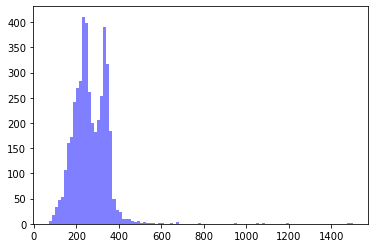

In [27]:
num_bins = 100
n, bins, patches = plt.hist(widths, num_bins, facecolor='blue', alpha=0.5)
plt.show()

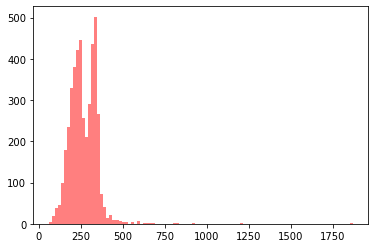

In [28]:
num_bins = 100
n, bins, patches = plt.hist(heights, num_bins, facecolor='red', alpha=0.5)
plt.show()

In [29]:
def resize_contain(image, size, resample=Image.LANCZOS, bg_color=(255, 255, 255, 255)):
    """
    Resize image according to size.
    image:      a Pillow image instance
    size:       a list of two integers [width, height]
    """
    img_format = image.format
    img = image.copy()
    img.thumbnail((size[0], size[1]), resample)
    background = Image.new('RGBA', (size[0], size[1]), bg_color)
    img_position = (
        int(math.ceil((size[0] - img.size[0]) / 2)),
        int(math.ceil((size[1] - img.size[1]) / 2))
    )
    background.paste(img, img_position)
    background.format = img_format
    return background.convert('RGBA')

In [30]:
def resize_to_max(fn_list, max_w, max_h):
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            if (w > max_w) or (h > max_h):
                res_im = resize_contain(image, [max_w, max_h])
                name=str(im).split('.')[0]
                res_im.save(f'{name}_512.tif', image.format)

In [31]:
def resize_all(fn_list, max_w, max_h, data_path, all_path):
    ''' using Pillow to resize to max_w ot h'''
    widths = []
    heights = []
    for im in fn_list:
        with pil_image.open(im) as image:
            w,h=image.size
            res_im = resize_contain(image, [max_w, max_h])
            name=str(im).split('.')[0]
            name=name.split('/')[-1]
            res_im.save(f'{data_path}/{name}.tif', image.format)
            shutil.copyfile(f'{data_path}/{name}.tif', all_path/f'{name}.tif')

#### OpenCV

In [32]:
def cv_resize_all(fn_list, max_size, data_path, all_path, color, border):
    ''' using OpenCV to resize to max_w ot h'''
    print(f'resizing: {len(fn_list)} images to: {max_size} with OpenCV border: {border}')
    widths = []
    heights = []
    for i, im in enumerate(fn_list):
        img = cv2.imread(str(im))
        old_size = img.shape[:2] # old_size is in (height, width) format
        ratio = float(max_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        # new_size should be in (width, height) format
        img = cv2.resize(img, (new_size[1], new_size[0])) 
        delta_w = max_size - new_size[1]
        delta_h = max_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        new_im = cv2.copyMakeBorder(img, top, bottom, left, right, border,
    value=color)
        name=str(im).split('.')[0]
        name=name.split('/')[-1]
        if i % 1000 == 0:
            print(f'saving {i}th image to: {data_path}/{name}.tif, copying to: {all_path}/{name}.tif')
        #write np array to image usinf PIL
        pim = Image.fromarray(new_im)
        pim.save(f'{data_path}/{name}.tif')
        #new_im.imwrite(f'{data_path}/{name}.tif', new_im)
        shutil.copyfile(f'{data_path}/{name}.tif', all_path/f'{name}.tif')

In [33]:
fnames[0]

PosixPath('data/colombia_borde_rural/cropped/train/7a1e7446.tif')

In [34]:
train_dir = Path('data/train')
train_dir.mkdir(exist_ok=True)
test_dir = Path('data/test')
test_dir.mkdir(exist_ok=True)

#### PIL gen resized images

In [35]:
train_sized_dir = Path(f'data/train/{img_size}')
train_sized_dir.mkdir(exist_ok=True)
test_sized_dir = Path(f'data/test/{img_size}')
test_sized_dir.mkdir(exist_ok=True)

#### OpenCV gen resized images

In [36]:
train_cv_dir = Path(f'data/train/rotated')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'data/train/rotated/clipped')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'data/train/rotated/clipped/{border}')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'data/train/rotated/clipped/{border}/{img_size}')
train_cv_dir.mkdir(exist_ok=True)
train_cv_dir = Path(f'data/train/rotated/clipped/{img_size}')
train_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'data/test/rotated')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'data/test/rotated/clipped')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'data/test/rotated/clipped/{border}')
test_cv_dir.mkdir(exist_ok=True)
test_cv_dir = Path(f'data/test/rotated/clipped/{border}/{img_size}')
test_cv_dir.mkdir(exist_ok=True)

### resize all images

In [37]:
def pil_resize_to(fnames, test_fnames, size=256):
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped/'
        t_dir = p/f'train/{size}'
        t_dir.mkdir(exist_ok=True)
        resize_all(fnames, size,size, data_path=f'{p}/train/{size}', all_path=data_dir/f'train/{size}')
        if r.strip() not in ['castries','gros_islet']:
            t_dir = p/f'test/{size}'
            t_dir.mkdir(exist_ok=True)
            resize_all(test_fnames, size, size, data_path=f'{p}/test/{size}', all_path=data_dir/f'test/{size}')

In [38]:
def cv_resize_to(fnames, test_fnames, color, size=256):
    for c, r in zip(country_list, region_list):
        print(f'--cv_resize_to {c} {r}')
        p=data_dir/f'{c}_{r}/cropped/'
        t_dir = p/f'train/rotated/clipped/{size}'
        t_dir.mkdir(exist_ok=True)
        cv_resize_all(fnames, size, data_path=f'{p}/train/rotated/clipped/{size}', all_path=data_dir/f'train/rotated/clipped/{border}/{size}', color=color, border=BORDER)
        if r.strip() not in ['castries','gros_islet']:
            t_dir = p/f'test/rotated/clipped/{size}'
            t_dir.mkdir(exist_ok=True)
            cv_resize_all(test_fnames, size, data_path=f'{p}/test/rotated/clipped/{size}', all_path=data_dir/f'test/rotated/clipped/{border}/{size}', color=color, border=BORDER)

In [39]:
if PIL_RESIZE_IMAGES:
    fl=[]
    tl=[]
    train_flat=[]
    test_flat=[]
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped/'
        fn = get_image_files(p/'train')
        fl.append(fn)
        if r.strip() not in ['castries','gros_islet']:
            tn = get_image_files(p/'test')
            tl.append(tn)
    train_flat = [item for sublist in fl for item in sublist]
    test_flat = [item for sublist in tl for item in sublist]
    resize_to(fnames=train_flat, test_fnames=test_flat, size=img_size)

In [40]:
if CV_RESIZE_IMAGES:
    #black for padding not covered by reflection
    color = [0, 0, 0]
    fl=[]
    tl=[]
    train_flat=[]
    test_flat=[]
    for c, r in zip(country_list, region_list):
        p=data_dir/f'{c}_{r}/cropped'
        pd = p/'train/rotated/clipped'
        fn=[pd/f'{f}' for f in listdir(pd) if isfile(join(pd, f))]
        assert (len(fn)>0)
        fl.append(fn)
        if r.strip() not in ['castries','gros_islet']:
            print(f'{c} region {r} test gen')
            pd = p/'test/rotated/clipped'
            tn = [pd/f'{f}' for f in listdir(pd) if isfile(join(pd, f))]
            assert (len(tn)>0)
            tl.append(tn)
    train_flat = [item for sublist in fl for item in sublist]
    test_flat = [item for sublist in tl for item in sublist]
    print(f'{len(train_flat)} train images; {len(test_flat)} test images')
    cv_resize_to(fnames=train_flat, test_fnames=test_flat, color=color, size=img_size)

colombia region borde_rural test gen
colombia region borde_soacha test gen
guatemala region mixco_1_and_ebenezer test gen
guatemala region mixco_3 test gen
st_lucia region dennery test gen
22553 train images; 7325 test images
--cv_resize_to colombia borde_rural
resizing: 22553 images to: 512 with OpenCV border: 4
saving 0th image to: data/colombia_borde_rural/cropped/train/rotated/clipped/512/7a1e7446.tif, copying to: data/train/rotated/clipped/reflect/512/7a1e7446.tif
saving 1000th image to: data/colombia_borde_rural/cropped/train/rotated/clipped/512/7a334d58.tif, copying to: data/train/rotated/clipped/reflect/512/7a334d58.tif
saving 2000th image to: data/colombia_borde_rural/cropped/train/rotated/clipped/512/7a442a92.tif, copying to: data/train/rotated/clipped/reflect/512/7a442a92.tif
saving 3000th image to: data/colombia_borde_rural/cropped/train/rotated/clipped/512/7a4466f6.tif, copying to: data/train/rotated/clipped/reflect/512/7a4466f6.tif
saving 4000th image to: data/colombia_bo

saving 17000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a42aca8.tif, copying to: data/train/rotated/clipped/reflect/512/7a42aca8.tif
saving 18000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a4099a4.tif, copying to: data/train/rotated/clipped/reflect/512/7a4099a4.tif
saving 19000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a1f7940.tif, copying to: data/train/rotated/clipped/reflect/512/7a1f7940.tif
saving 20000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a351728.tif, copying to: data/train/rotated/clipped/reflect/512/7a351728.tif
saving 21000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a337742.tif, copying to: data/train/rotated/clipped/reflect/512/7a337742.tif
saving 22000th image to: data/colombia_borde_soacha/cropped/train/rotated/clipped/512/7a26c614.tif, copying to: data/train/rotated/clipped/reflect/512/7a26c614.tif
resizing: 7325 i

saving 2000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a442a92.tif, copying to: data/train/rotated/clipped/reflect/512/7a442a92.tif
saving 3000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a4466f6.tif, copying to: data/train/rotated/clipped/reflect/512/7a4466f6.tif
saving 4000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a2de9da.tif, copying to: data/train/rotated/clipped/reflect/512/7a2de9da.tif
saving 5000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a2f7d68.tif, copying to: data/train/rotated/clipped/reflect/512/7a2f7d68.tif
saving 6000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a3d6edc.tif, copying to: data/train/rotated/clipped/reflect/512/7a3d6edc.tif
saving 7000th image to: data/guatemala_mixco_3/cropped/train/rotated/clipped/512/7a25951e.tif, copying to: data/train/rotated/clipped/reflect/512/7a25951e.tif
saving 8000th image to: data/guatemala_mixco_3

saving 22000th image to: data/st_lucia_castries/cropped/train/rotated/clipped/512/7a26c614.tif, copying to: data/train/rotated/clipped/reflect/512/7a26c614.tif
--cv_resize_to st_lucia dennery
resizing: 22553 images to: 512 with OpenCV border: 4
saving 0th image to: data/st_lucia_dennery/cropped/train/rotated/clipped/512/7a1e7446.tif, copying to: data/train/rotated/clipped/reflect/512/7a1e7446.tif
saving 1000th image to: data/st_lucia_dennery/cropped/train/rotated/clipped/512/7a334d58.tif, copying to: data/train/rotated/clipped/reflect/512/7a334d58.tif
saving 2000th image to: data/st_lucia_dennery/cropped/train/rotated/clipped/512/7a442a92.tif, copying to: data/train/rotated/clipped/reflect/512/7a442a92.tif
saving 3000th image to: data/st_lucia_dennery/cropped/train/rotated/clipped/512/7a4466f6.tif, copying to: data/train/rotated/clipped/reflect/512/7a4466f6.tif
saving 4000th image to: data/st_lucia_dennery/cropped/train/rotated/clipped/512/7a2de9da.tif, copying to: data/train/rotated/c

saving 19000th image to: data/st_lucia_gros_islet/cropped/train/rotated/clipped/512/7a1f7940.tif, copying to: data/train/rotated/clipped/reflect/512/7a1f7940.tif
saving 20000th image to: data/st_lucia_gros_islet/cropped/train/rotated/clipped/512/7a351728.tif, copying to: data/train/rotated/clipped/reflect/512/7a351728.tif
saving 21000th image to: data/st_lucia_gros_islet/cropped/train/rotated/clipped/512/7a337742.tif, copying to: data/train/rotated/clipped/reflect/512/7a337742.tif
saving 22000th image to: data/st_lucia_gros_islet/cropped/train/rotated/clipped/512/7a26c614.tif, copying to: data/train/rotated/clipped/reflect/512/7a26c614.tif


In [41]:
len(train_flat)

22553

In [42]:
len(test_flat)

7325

In [43]:
train_flat[0]

PosixPath('data/colombia_borde_rural/cropped/train/rotated/clipped/7a1e7446.tif')

In [44]:
train_ids=df_all['id']

In [45]:
p=data_dir/f'train/rotated/clipped/{border}/{img_size}'

In [46]:
all_cv_train_fnames = [p/f'{f}' for f in listdir(p) if isfile(join(p, f))]

In [47]:
train_ids

0       7a3f2a10
1       7a1f731e
2       7a424ad8
3       7a3edc5e
4       7a303a6e
5       7a1eb2bc
6       7a2c2a64
7       7a2c92ba
8       7a28a24a
9       7a38a5b4
10      7a349f28
11      7a371a32
12      7a44a472
13      7a2fc05c
14      7a41c798
15      7a21eea0
16      7a31c942
17      7a2d66d6
18      7a2f33ee
19      7a38cd5a
20      7a38c0ee
21      7a2187f8
22      7a3b0aa2
23      7a339bdc
24      7a303cf8
25      7a3a2858
26      7a38b1c6
27      7a2f5d7e
28      7a372928
29      7a35666a
          ...   
1937    7a36a80e
1938    7a2d4f84
1939    7a2fd704
1940    7a37d918
1941    7a3c90f2
1942    7a4248a8
1943    7a1e24dc
1944    7a344b04
1945    7a29945c
1946    7a1ecebe
1947    7a424470
1948    7a372b3a
1949    7a276c86
1950    7a3c6c30
1951    7a364a4e
1952    7a3bda90
1953    7a419b74
1954    7a25a3c4
1955    7a1e8f26
1956    7a2becd4
1957    7a2cf796
1958    7a2ff522
1959    7a23e156
1960    7a410894
1961    7a23a86c
1962    7a22ddec
1963    7a2f73ea
1964    7a34ff

In [48]:
assert(set(train_ids) == set(all_cv_train_fnames))

AssertionError: 

In [ ]:
test_ids=df_test['id']

In [ ]:
p=data_dir/f'test/rotated/clipped/{border}/{img_size}'

In [ ]:
all_cv_test_fnames = [p/f'{f}' for f in listdir(p) if isfile(join(p, f))]
len(all_cv_test_fnames)

In [ ]:
assert(set(test_ids) == set(all_cv_test_fnames))